<a href="https://colab.research.google.com/github/kamyarMhd/facial-expression-by-prompt/blob/main/kamyar_mohammadi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing...
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import models
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Loading images from Colab

In [3]:
# Mounting google drive to read some files from there
#  I uploaded all the necessary stuff on Google Drive in order to be faster in each different run
import os
from google.colab import drive
driver_directory = '/drive'
if not os.path.exists(driver_directory):
  drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Make a new directory named source_image to put my images there
!mkdir source_image

In [5]:
cp /content/drive/MyDrive/data.zip /content/source_image/data.zip # Copy source image from google drive to source_image

In [6]:
# Extract source images to in source_image
!unzip /content/source_image/data.zip -d /content/source_image

Archive:  /content/source_image/data.zip
  inflating: /content/source_image/ffhq-h1.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h1.png  
  inflating: /content/source_image/ffhq-h2.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h2.png  
  inflating: /content/source_image/ffhq-h3.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h3.png  
  inflating: /content/source_image/ffhq-h4.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h4.png  
  inflating: /content/source_image/ffhq-h5.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h5.png  
  inflating: /content/source_image/ffhq-h6.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h6.png  
  inflating: /content/source_image/ffhq-h7.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h7.png  
  inflating: /content/source_image/ffhq-h8.png  
  inflating: /content/source_image/__MACOSX/._ffhq-h8.png  
  inflating: /content/source_image/ffhq-h9.png  
  inflating: /content/source_image/__M

# Cropping Faces
In the following function, I want to crop faces from images and resave them in the same directory. The reason for doing this is that in the feature I need to find the most similar source image with an input image

In [7]:
import cv2 # import openCV library

def crop_face(src_img):

  img = cv2.imread(src_img) # read the input image

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale of each frames

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # read the haarcascade to detect the faces in an image

  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))  # Detect faces

  # if the function detected more than 1 face or it does not detect any faces it returns 0,0. (Due to the nature of the source images, this rarely happens)
  if len(faces) > 0:
    x, y, w, h = faces[0] # start point and width and hight of the image


    face = img[y:y + h, x:x + w] # detected face
    face = torch.tensor(face[:, :, ::-1].copy()) # change order of channel: from BGR ---> RBG
    face=F.interpolate(face.unsqueeze(0).permute(0, 3, 1, 2), size=(1024, 1024), mode='bilinear', align_corners=False) # Resize cropped images to 1024 x 1024
    face = face.squeeze(0) # Remove first dim of tensor that added in previous line because of interpolate: (1 x 1024 x 1024 x 3) ---> (1024 x 1024 x 3)
    face = face/255 # transfor values to interval [0, 1]
    return len(faces), face
  else:
    return 0, 0


In [ ]:
expressions = ['ffhq-h', 'ffhq-p', 'ffhq-s'] # There are three kind of expressions in data (h: Happy, p: Poker, s: Sad)

for expression in expressions: # Cropping faces over all expressions

  for i in range(1,101):
    num_face, cropped = crop_face(src_img=f'source_image/{expression}{i}.png')
    if num_face == 1: # if model can not detect face or it detects more than one faces we do not crop it
      save_image(cropped, f"source_image/{expression}{i}.png") # I overwrite cropped face on original images




# Extracting Features
I use the following class VGG16_for_Perceptual to extract features from different layers of VGG16 models.

In [8]:
cp /content/drive/MyDrive/karras2019stylegan-ffhq-1024x1024.for_g_all.pt /content/karras2019stylegan-ffhq-1024x1024.pt # This file contains pre-trained weights and biases on the original StyleGAN model in Pytorch

In [9]:
class VGG16_for_Perceptual(torch.nn.Module):
    def __init__(self,requires_grad=False,n_layers=[2,4,14,21]):# I use layers (2, 3, 10(after pooling), 16)
        super(VGG16_for_Perceptual,self).__init__()
        vgg_pretrained_features=models.vgg16(pretrained=True).features #The VGG16 pretrained model's feature extraction layers are loaded

        self.slice0=torch.nn.Sequential() # I create 4 empty Sequential modules to store different slices of layers.
        self.slice1=torch.nn.Sequential()
        self.slice2=torch.nn.Sequential()
        self.slice3=torch.nn.Sequential()


        # Iterating over the indices specified in n_layers to populate each slice with the corresponding layers
        # This effectively extracts specific feature maps at different layers of the model
        for x in range(n_layers[0]):#relu1_1
            self.slice0.add_module(str(x),vgg_pretrained_features[x])
        for x in range(n_layers[0],n_layers[1]): #relu1_2
            self.slice1.add_module(str(x),vgg_pretrained_features[x])
        for x in range(n_layers[1],n_layers[2]): #relu3_2
            self.slice2.add_module(str(x),vgg_pretrained_features[x])
        for x in range(n_layers[2],n_layers[3]):#relu4_2
            self.slice3.add_module(str(x),vgg_pretrained_features[x])

        # Freeze the model's weights during training
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False



    def forward(self,x): # Passing an input tensor x through the different slices of layers
        h0=self.slice0(x)
        h1=self.slice1(h0)
        h2=self.slice2(h1)
        h3=self.slice3(h2)

        return h0,h1,h2,h3 # Returning different features in diferrent layers


#Defining my StyleGAN-based architecture components
In some of the following blocks, I will define different components of a StyleGAN-based architecture in different classes

###Custom Linear class

First I define a custom linear layer class called MyLinear. This layer implements equalized learning rate and custom learning rate multiplier techniques



In [10]:
class MyLinear(nn.Module):

    # gain is a scaling factor for initializing weights.
    # use_wscale is a boolean indicating whether to use weight scaling
    # lrmul is learning rate
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He initialization; It calculates the standard deviation for weight initialization

        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale: # Use weight scaling or not...
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std) # Trainable weights parameters for Linear layer.
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias) # Linear transformation is performed using F.linear.

###Custom convolutional layer class

Here I define a custom convolutional layer class called MyConv2d. This layer implements equalized learning rate and custom learning rate multiplier techniques

In [11]:
class MyConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, stride=1, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None

        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He initialization
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std) # Trainable weights parameters for Convolutional layer.
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None: # If bias is included ---> update it
            bias = bias * self.b_mul

        have_convolution = False # It is for showing if Convolution is applied or not.
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128: # Fused upscale
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1)) # add Padding
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1] # Entries within each subregion are summed up
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2) # Convolution transpose
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)



        intermediate = self.intermediate
        if not have_convolution and intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)

        if intermediate is not None:
            x = intermediate(x)

        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

###Custom noise layer
This layer is designed to add noise to input data and allow per-channel control over the amount of noise applied to each channe

In [12]:
class NoiseLayer(nn.Module):

    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels)) # A trainable weight parameter for each channel

    def forward(self, x):
        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype) # Random noise with equal size of input for each channel
        x = x + self.weight.view(1, -1, 1, 1) * noise # Update input
        return x

### Style Modulation
Performs style modulation on the input tensor using style vectors obtained from a linear layer

In [13]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size, # The size of the latent style vector: 512
                            channels * 2, #  For each channel in the input tensor, two values are needed from the style vector: one for Scale and one for Bias
                            gain=1.0, use_wscale=use_wscale)

    def forward(self, x, latent):
        style = self.lin(latent) # Style ---> producing a style vector with twice the number of channels as the input tensor
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]. Reshaped to match the shape of the input tensor x but with an additional dimension for style modulation
        x = x * (style[:, 0] + 1.) + style[:, 1] # Multiplied by the first half of the style vector, and added with the second half of the style vector
        return x

###Blur Layer
That implements a blurring operation using a specified kernel. This blurring operation is applied to input tensors using convolution

In [14]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], stride=1):
        super(BlurLayer, self).__init__()
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None] # Specify a 2D convolutional kernel
        kernel = kernel / kernel.sum() # Normalize the kernel

        self.register_buffer('kernel', kernel)
        self.stride = stride

    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1) # eExpand to match the number of channels
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

###Upscaled Layer
I use this class in order to increase the spatial dimensions of the input. It causes an increase in the spatial resolution of images during the generation process.

In [15]:
class Upscale2d(nn.Module):
    def __init__(self, factor=2):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.factor = factor
    def forward(self, x):
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, self.factor, -1, self.factor) # Expanding input
        x = x.contiguous().view(shape[0], shape[1], self.factor * shape[2], self.factor * shape[3]) # Reshaping input in a contiguous memory
        return x

### Epilogue Layer
This class is responsible for defining and applying various operations to the input data, including noise, activation, normalization, and style modulation based on the provided configuration

Things to do at the end of each layer...

In [16]:
class LayerEpilogue(nn.Module):
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = [] # Layers that need to be run
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers)) # This sequence of layers represents the operations to be performed at the end of each layer
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x) # In the forward pass, the input x is processed through the layers defined in self.top_epi
        if self.style_mod is not None: # Style modulation
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x

###Input Block
This block is used at the beginning of the network to handle the input data.
This block plays a crucial role in mapping the latent vectors to the image space.


In [17]:
class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, gain, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.nf = nf # The number of filters or feature maps for this input block
        self.const = nn.Parameter(torch.ones(1, nf, 4, 4)) # Initial constant input to the generator network. to be more stable...
        self.bias = nn.Parameter(torch.ones(nf))

        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer)

    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        x = self.const.expand(batch_size, -1, -1, -1)
        x = x + self.bias.view(1, -1, 1, 1)

        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x # Input for subsequent layers in the generator network

###Synthesis Block
This class defines a building block that includes upscaling, convolution, and style modulation operations. It plays a role in increasing the spatial resolution of the feature maps while allowing for style-based control over the appearance of the generated content

In [18]:
class GSynthesisBlock(nn.Module):

  def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer):
    # 2**res x 2**res # res = 3..resolution_log2
    super().__init__()
    if blur_filter:
      blur = BlurLayer(blur_filter)
    else:
      blur = None
    self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                             intermediate=blur, upscale=True)
    self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer)
    self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
    self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_instance_norm, use_styles, activation_layer)

  def forward(self, x, dlatents_in_range):
    x = self.conv0_up(x) # x is first passed through an upscaling operation. This increases the spatial resolution of the feature maps
    x = self.epi1(x, dlatents_in_range[:, 0])
    x = self.conv1(x)
    x = self.epi2(x, dlatents_in_range[:, 1])
    return x




###G_synthesis Class
This is the key part of our StyleGAN. It's responsible for synthesizing images with a specific resolution and structure.

This class defines the architecture and forward pass of the generator, and it is responsible for converting latent vectors into high-resolution RGB images with control over style and appearance.

In [19]:
class G_synthesis(nn.Module):

  def __init__(self,
  dlatent_size        = 512,          # Dimensionality of the latent vectors (W).
  num_channels        = 3,            # Number of output color channels.
  resolution          = 1024,         # Output resolution.
  fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
  fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
  fmap_max            = 512,          # Maximum number of feature maps in any layer.
  use_styles          = True,         # Enable style inputs?
  use_noise           = True,         # Enable noise inputs?
  randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
  nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
  use_wscale          = True,         # Enable equalized learning rate?
  use_instance_norm   = True,         # Enable instance normalization?
  dtype               = torch.float32,  # Data type to use for activations and outputs.
  fused_scale         = 'auto',       # True = fused convolution + scaling, False = separate ops, 'auto' = decide automatically.
  blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.



  ):

    super().__init__()
    def nf(stage): # Calculates the number of feature maps (channels)
      return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
    self.dlatent_size = dlatent_size

    resolution_log2 = int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4


    act, gain = {'relu': (torch.relu, np.sqrt(2)),'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
    num_layers = resolution_log2 * 2 - 2
    num_styles = num_layers if use_styles else 1
    # torgbs = []
    blocks = []
    for res in range(2, resolution_log2 + 1): # Appending blocks for different layer, where each layer corresponds to a different resolution level of the image.
      channels = nf(res-1)
      name = '{s}x{s}'.format(s=2**res)
      if res == 2:
          blocks.append((name,InputBlock(channels, dlatent_size, gain, use_wscale,
                                         use_noise, use_instance_norm, use_styles, act))) # First layer

      else:
          blocks.append((name,GSynthesisBlock(last_channels, channels, blur_filter,
                                              dlatent_size, gain, use_wscale, use_noise, use_instance_norm, use_styles, act))) # Other layers
      last_channels = channels
    self.torgb = MyConv2d(channels,num_channels, 1,gain=1, use_wscale=use_wscale) # The final result synthesized RGB image, the output of the last block through a convolutional layer
    self.blocks = nn.ModuleDict(OrderedDict(blocks)) # It contains an ordered dictionary, keys are the names of the blocks (e.g., "8x8", "16x16" etc.), values are the corresponding block instances (e.g., instances of InputBlock or GSynthesisBlock).

  def forward(self,dlatents_in):

    batch_size = dlatents_in.size(0)
    for i, m in enumerate(self.blocks.values()): # Iterate through the layers

        if i == 0:
            x = m(dlatents_in[:, 2*i:2*i+2])
        else:
            x = m(x,dlatents_in[:, 2*i:2*i+2])



    rgb = self.torgb(x)

    return rgb

# Image Reader Function
This function is designed to read images from a specific resource in different parts of the model

In [20]:
import PIL
from torchvision import transforms
from PIL import Image
def image_reader(img_path,resize=None):

    with open(img_path,"rb") as f:
        image=Image.open(f)
        image=image.convert("RGB")
    if resize!=None:
        image=image.resize((resize,resize))
    transform = transforms.Compose([
    transforms.ToTensor()
    ])

    image = transform(image)


    image=image.unsqueeze(0)

    return image

# Encode Function
This function is designed to encode the input image to a latent space that can generate input image

In [21]:
!mkdir save_image # Make a new directory named save_image to save the results there
!mkdir save_image/encode1 # Make a new sub-directory named encode1 to save the results of encoded image generated based on latent space
!mkdir latent_W # Make a new directory named latent_W to save the latent vectors

In [22]:
def encode_image(src_img, src_dir="source_image/", weight_file='karras2019stylegan-ffhq-1024x1024.pt', iteration=501, resolution=1024):


  g_synthesis =  nn.Sequential(OrderedDict([('g_synthesis', G_synthesis(resolution=resolution))])) # The synthesis network generates images based on the latent representation
  weights = torch.load(weight_file, map_location=device).items() # Loading weights of pre-trained StyleGAN
  weights = list(weights)[16:] # Slicing and choising only parts related to the synthesis. (Removing mapping)
  weights = OrderedDict(weights)
  g_synthesis.load_state_dict(weights) # Loading wights to our g_synthesis
  g_synthesis.eval()
  g_synthesis.to(device)


  # Reading input image
  name=src_img.split('.')[0]
  img=image_reader(src_dir+src_img)
  img=img.to(device)


  MSE_Loss=nn.MSELoss(reduction="mean")

  img_p=img.clone() # For perceptual loss
  upsample2d=torch.nn.Upsample(scale_factor=256/resolution, mode='bilinear') # Resized to (256,256) for VGG input
  img_p=upsample2d(img_p)

  perceptual_net=VGG16_for_Perceptual(n_layers=[2,4,14,21]).to(device) # These indices indicate which layers of the VGG16 architecture will be used for feature extraction
  dlatent=torch.zeros((1,18,512),requires_grad=True,device=device)
  optimizer=optim.Adam({dlatent},lr=0.01,betas=(0.9,0.999),eps=1e-8)

  print("Start Encoding...")
  loss_list=[]
  for i in range(iteration):
    optimizer.zero_grad()
    synth_img=g_synthesis(dlatent) # passing latent vector in order to produce image
    synth_img = (synth_img + 1.0) / 2.0 # Transform from the range of [-1, 1] ---> to  range of [0, 1]
    mse_loss,perceptual_loss=caluclate_loss(synth_img,img,perceptual_net,img_p,MSE_Loss,upsample2d) # Calculating losses between input image and generated image
    loss=mse_loss+perceptual_loss
    loss.backward()

    optimizer.step()

    loss_np=loss.detach().cpu().numpy()
    loss_p=perceptual_loss.detach().cpu().numpy()
    loss_m=mse_loss.detach().cpu().numpy()
    loss_list.append(loss_np)

    if (i%500==0) & (i>0):
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}".format(i,loss_np,loss_m,loss_p))
      print('')
      save_image(synth_img.clamp(0,1),"save_image/encode1/{}.png".format(i))
      np.save("latent_W/{}.npy".format(name),dlatent.detach().cpu().numpy())
      # dlatent.requires_grad=False

    if loss_p<1:
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}".format(i,loss_np,loss_m,loss_p))
      print('')
      save_image(synth_img.clamp(0,1),"save_image/encode1/{}.png".format(name))
      np.save("latent_W/{}.npy".format(name),dlatent.detach().cpu().numpy())
      # dlatent.requires_grad=False
      break


#Loss function
def caluclate_loss(synth_img,img,perceptual_net,img_p,MSE_Loss,upsample2d):

  mse_loss=MSE_Loss(synth_img,img) # Calculate MSE Loss


  # Calculate Perceptual Loss
  real_0,real_1,real_2,real_3=perceptual_net(img_p) #img_p is already resized ----> size of real_x = (1, 64, 256, 256)
  synth_p=upsample2d(synth_img) # synth_img needs to be resized: (1, 3, 1024, 1024) ---> (1, 3, 256, 256)
  synth_0,synth_1,synth_2,synth_3=perceptual_net(synth_p)


  perceptual_loss=0
  perceptual_loss += MSE_Loss(synth_0,real_0)
  perceptual_loss += MSE_Loss(synth_1,real_1)
  perceptual_loss += MSE_Loss(synth_2,real_2)
  perceptual_loss += MSE_Loss(synth_3,real_3)

  return mse_loss,perceptual_loss

In [23]:
cp /content/drive/MyDrive/latent_W.zip /content/latent_W/latent_W.zip

In [24]:
!unzip /content/latent_W/latent_W.zip -d /content/latent_W

Archive:  /content/latent_W/latent_W.zip
  inflating: /content/latent_W/ffhq-h1.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h1.npy  
  inflating: /content/latent_W/ffhq-h2.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h2.npy  
  inflating: /content/latent_W/ffhq-h3.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h3.npy  
  inflating: /content/latent_W/ffhq-h4.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h4.npy  
  inflating: /content/latent_W/ffhq-h5.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h5.npy  
  inflating: /content/latent_W/ffhq-h6.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h6.npy  
  inflating: /content/latent_W/ffhq-h7.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h7.npy  
  inflating: /content/latent_W/ffhq-h8.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h8.npy  
  inflating: /content/latent_W/ffhq-h9.npy  
  inflating: /content/latent_W/__MACOSX/._ffhq-h9.npy  
  inflating: /content/latent_W/ffhq-h10.npy  
  in

**If you have run two above cells you do not need to run the following cell**

In [ ]:
expressions = ['ffhq-h', 'ffhq-p', 'ffhq-s']
for expression in expressions: # Calculate latent spaces of our data(100 images for each expression)
  for i in range(1,101):
     encode_image(src_img=f'{expression}{i}.png')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 263MB/s]


Start
iter500: loss -- 3.1856842041015625,  mse_loss --0.016871724277734756,  percep_loss --3.1688125133514404
Start
iter500: loss -- 2.380765438079834,  mse_loss --0.025892939418554306,  percep_loss --2.354872465133667
Start
iter500: loss -- 2.004981756210327,  mse_loss --0.04439081251621246,  percep_loss --1.9605908393859863
Start
iter500: loss -- 3.0273332595825195,  mse_loss --0.01674555614590645,  percep_loss --3.010587692260742
Start
iter500: loss -- 2.656337022781372,  mse_loss --0.02714131399989128,  percep_loss --2.6291956901550293
Start
iter500: loss -- 2.947007656097412,  mse_loss --0.023110315203666687,  percep_loss --2.9238972663879395
Start
iter500: loss -- 1.9519940614700317,  mse_loss --0.014807049185037613,  percep_loss --1.9371869564056396
Start
iter500: loss -- 1.7834670543670654,  mse_loss --0.01092554908245802,  percep_loss --1.7725415229797363
Start
iter500: loss -- 2.384483575820923,  mse_loss --0.016437359154224396,  percep_loss --2.368046283721924
Start
iter500

#Transfere Expression function
This function is responsible for transferring expression.

In [25]:
!mkdir save_image/exchange # Make a new sub-directory named exchange to save the results of expression transfer there
!mkdir save_image/exchange/expression # Make a new sub-directory named expression to save the results of the generated expression source
!mkdir save_image/exchange/source_style # Make a new sub-directory named source_style to save the results of the generated style of the source image
!mkdir save_image/exchange/transferred # Make a new sub-directory named transferred to save the results of the generated transferred expression on the source image

In [26]:
def transfer_expression(src_img1,src_img2, src_dir="source_image/", weight_file='karras2019stylegan-ffhq-1024x1024.pt', iteration=501, resolution=1024):


  g_synthesis =  nn.Sequential(OrderedDict([('g_synthesis', G_synthesis(resolution=resolution))])) # The synthesis network generates images based on the latent representation
  weights = torch.load(weight_file, map_location=device).items() # Loading weights of pre-trained StyleGAN
  weights = list(weights)[16:] # Slicing and choising only parts related to the synthesis. (Removing mapping)
  weights = OrderedDict(weights)
  g_synthesis.load_state_dict(weights) # Loading wights to our g_synthesis
  g_synthesis.eval()
  g_synthesis.to(device)


  # Read images
  name=src_img1.split('.')[0]
  img_0=image_reader(src_dir+src_img1)
  img_0=img_0.to(device)

  name=src_img2.split('.')[0]
  img_1=image_reader(src_dir+src_img2)
  img_1=img_1.to(device)


  MSE_Loss=nn.MSELoss(reduction="mean")
  upsample2d=torch.nn.Upsample(scale_factor=0.5, mode='bilinear') # Resized to (256,256) for VGG input

  img_p0=img_0.clone() # Resize for perceptual net
  img_p0=upsample2d(img_p0)
  img_p0=upsample2d(img_p0) # (1,3,256,256)

  img_p1=img_1.clone()
  img_p1=upsample2d(img_p1)
  img_p1=upsample2d(img_p1) # (1,3,256,256)


  perceptual_net=VGG16_for_Perceptual(n_layers=[2,4,14,21]).to(device) # conv1_1,conv1_2,conv2_2,conv3_3
  dlatent_a=torch.zeros((1,18,512),requires_grad=True,device=device) # appearace latent s1
  dlatent_e=torch.zeros((1,18,512),requires_grad=True,device=device) # expression latent s2
  optimizer=optim.Adam({dlatent_a,dlatent_e},lr=0.01,betas=(0.9,0.999),eps=1e-8)

  alpha=torch.zeros((1,18,512)).to(device) # A mask to choose the expression from the first input and style from the second one
  alpha[:,3:5,:]=1

  print("Start Transfer Expression...")
  loss_list=[]
  for i in range(iteration):
    optimizer.zero_grad()
    synth_img_a=g_synthesis(dlatent_a) # Generate the image that one its expression we need
    synth_img_a= (synth_img_a + 1.0) / 2.0

    synth_img_e=g_synthesis(dlatent_e) # Generate the target image based on style loss (without changing expression)
    synth_img_e= (synth_img_e + 1.0) / 2.0

    loss_1=caluclate_contentloss(synth_img_a,perceptual_net,img_p0,MSE_Loss,upsample2d) # Calculate loss for expression image
    loss_1.backward()

    optimizer.step()

    loss_2=caluclate_styleloss(synth_img_e,img_p1,perceptual_net,upsample2d) # # Calculate loss for target image style
    loss_2.backward()
    optimizer.step()

    loss_1=loss_1.detach().cpu().numpy()
    loss_2=loss_2.detach().cpu().numpy()



    dlatent1=dlatent_a*alpha+dlatent_e*(1-alpha) # Applying mask to produce latent space of our transferred expression image based on the two others images

    synth_img1=g_synthesis(dlatent1) # Generate transferred expression image
    synth_img1= (synth_img1 + 1.0) / 2.0


    if i%100==0:
      print("iter{}:   loss0 --{},  loss1 --{}".format(i,loss_1,loss_2))
      save_image(synth_img_a.clamp(0,1),"save_image/exchange/expression/{}_expression.png".format(i))
      save_image(synth_img_e.clamp(0,1),"save_image/exchange/source_style/{}_source_style.png".format(i))
      save_image(synth_img1.clamp(0,1),"save_image/exchange/transferred/{}_transferred.png".format(i))
      np.save("latent_W/exchange1.npy",dlatent1.detach().cpu().numpy())

      # if i==500:
      #   dlatent_a.requires_grad=False
      #   dlatent_e.requires_grad=False












def caluclate_contentloss(synth_img,perceptual_net,img_p,MSE_Loss,upsample2d): # Calculate loss function for expression Image

  real_0,real_1,real_2,real_3=perceptual_net(img_p)
  synth_p=upsample2d(synth_img) #(1,3,256,256)
  synth_p=upsample2d(synth_p)
  synth_0,synth_1,synth_2,synth_3=perceptual_net(synth_p)

  perceptual_loss=0
  perceptual_loss+=MSE_Loss(synth_0,real_0)
  perceptual_loss+=MSE_Loss(synth_1,real_1)
  perceptual_loss+=MSE_Loss(synth_2,real_2)
  perceptual_loss+=MSE_Loss(synth_3,real_3)


  return perceptual_loss



class StyleLoss(nn.Module): # Calculate  the style loss between the feature representations of the target image and an initial image
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()
  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return self.loss
  def gram_matrix(self,input): # Gram matrix of the target feature representation
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)




def caluclate_styleloss(synth_img,img_p,perceptual_net,upsample2d): # Calculate style loss between synthesized image and target image

  synth_p=upsample2d(synth_img) #(1,3,256,256)
  synth_p=upsample2d(synth_p)

  _,_,_,style_real=perceptual_net(img_p) # Just features from conv3_3 layer are useful
  _,_,_,style_synth=perceptual_net(synth_p)

  style_loss=StyleLoss(style_real)

  loss=style_loss(style_synth)

  return loss



###Find Similar function
I defined this function to find the most similar image compared to the input image based on the input prompt based on cosine similarity

In [27]:
from numpy.linalg import norm
def find_similar(src_img, prompt, src_dir="latent_W/"):

  # with torch.no_grad():
  encode_image(src_img=src_img) # Encode input image

  name=src_img.split('.')[0]
  latent_src = np.load(f'latent_W/{name}.npy') # load latent vector of input image
  similar_img=''
  similarity_tempt = -1
  index_of_similar = 0
  for i in range(1, 101): # Find most similar image based on them latent vectors and cosine similarity
    if prompt == 'happy':
      tempt_latent = np.load(f'{src_dir}/ffhq-h{i}.npy')
    elif prompt == 'sad':
      tempt_latent = np.load(f'{src_dir}/ffhq-s{i}.npy')
    elif prompt == 'poker':
      tempt_latent = np.load(f'{src_dir}/ffhq-p{i}.npy')
    else:
      print("Invalid input prompt")
      break
    dot_product = np.dot(latent_src.reshape(-1), tempt_latent.reshape(-1))
    magnitude_latent_src = norm(latent_src.reshape(-1))
    magnitude_tempt_latent = norm(tempt_latent.reshape(-1))

    similarity = dot_product / (magnitude_latent_src * magnitude_tempt_latent)

    if similarity>similarity_tempt:
      similarity_tempt=similarity
      index_of_similar = i
      if prompt =='happy':
        similar_img = f'ffhq-h{i}.png'
      elif prompt == 'sad':
        similar_img = f'ffhq-s{i}.png'
      else:
        similar_img = f'ffhq-p{i}.png'

  print(f'Most similar image is {index_of_similar}th source image. with similarity equal to {similarity}.')
  print('')

  return similar_img # Return name of most similar image based on input prompt



###Change Expression function
I defined this function to transfer facial expressions of most similar image and input image based on the input prompt.

In [28]:
def change_expression(src_img, prompt, src_dir="latent_W"):

  similar_img = find_similar(src_img=src_img, prompt=prompt, src_dir=src_dir)
  if similar_img!= '':
    transfer_expression(src_img1=similar_img, src_img2=src_img)


#Wrap and Blend
Wrapping and blending result of transferred image with original image based on the landmarks

In [29]:
cp /content/drive/MyDrive/shape_predictor_68_face_landmarks.dat /content/shape_predictor_68_face_landmarks.dat # pre-trained facial landmark detection model

In [30]:
import cv2
import numpy as np
import scipy.spatial as spatial
import logging
import dlib

###Detect Face function
Identify facial landmarks within input face, and provide a cropped region of the face for further processing

In [31]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # Loads pre-trained facial landmark predictor
def detect_face(im, r=10):

    detector = dlib.get_frontal_face_detector() # Initializes a face detector
    faces = detector(im) # Detect face


    idx = np.argmax([(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]) # Selecting the bounding box
    bbox = faces[idx]


    shape = predictor(im, bbox) # Detect the 68 facial landmarks within the bounding box (bbox) of the detected face using predictor


    points = np.asarray(list([p.x, p.y] for p in shape.parts()), dtype=int) # Convert the detected facial landmarks into a NumPy array (points)


    im_w, im_h = im.shape[:2] # Calculating min and max of x and y coordinates for determining the bounding box of all the facial landmarks.
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)

    x, y = max(0, left - r), max(0, top - r) # Cropping a slightly larger region around the face
    w, h = min(right + r, im_h) - x, min(bottom + r, im_w) - y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y + h, x:x + w]


###Destination Face function


In [32]:
def dstination_face(im, r=10):

    detector = dlib.get_frontal_face_detector()
    faces = detector(im)


    faceBoxe = {"points" : None,
                      "shape" : None,
                      "face" : None}

    idx = np.argmax([(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces])
    bbox = faces[idx]

    ## Face and points detection
    # Get the landmarks/parts for the face in box d.
    shape = predictor(im, bbox)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    points = np.asarray(list([p.x, p.y] for p in shape.parts()), dtype=int)

    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)

    x, y = max(0, left - r), max(0, top - r)
    w, h = min(right + r, im_h) - x, min(bottom + r, im_w) - y
    faceBoxe["points"] = points - np.asarray([[x, y]])
    faceBoxe["shape"] = (x, y, w, h)
    faceBoxe["face"] = im[y:y + h, x:x + w]

    return faceBoxe

###Face Swap

In [33]:
# 3D Transform
def bilinear_interpolate(img, coords): # Interpolates over every image channel

    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0 + 1]
    q12 = img[y0 + 1, x0]
    q22 = img[y0 + 1, x0 + 1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

def grid_coordinates(points): # x,y grid coordinates within the ROI of supplied points

    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1

    return np.asarray([(x, y) for y in range(ymin, ymax)
                       for x in range(xmin, xmax)], np.uint32)


def process_warp(src_img, result_img, tri_affines, dst_points, delaunay): # Warping each triangle from src_img into result_img but only within the region of interest (ROI) defined by dst_points

    roi_coords = grid_coordinates(dst_points)
    roi_tri_indices = delaunay.find_simplex(roi_coords)

    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index],
                            np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)

    return None


def triangular_affine_matrices(vertices, src_points, dst_points): # Calculate the affine transformation matrix for each triangle (x,y) vertex from dst_points to src_points

    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dst_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat


def warp_image_3d(src_img, src_points, dst_points, dst_shape, dtype=np.uint8): # Performs a 3D warp of src_img to a  dst_shape using affine transformations for each triangle in the Delaunay triangulation of the destination landmarks

    rows, cols = dst_shape[:2]
    result_img = np.zeros((rows, cols, 3), dtype=dtype)

    delaunay = spatial.Delaunay(dst_points)
    tri_affines = np.asarray(list(triangular_affine_matrices(
        delaunay.simplices, src_points, dst_points)))

    process_warp(src_img, result_img, tri_affines, dst_points, delaunay)

    return result_img




def mask_from_points(size, points,erode_flag=1): # Generate Mask

    radius = 10  # kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
    if erode_flag:
        mask = cv2.erode(mask, kernel,iterations=1)

    return mask


## Color Correction
def correct_colours(im1, im2, landmarks1):
    COLOUR_CORRECT_BLUR_FRAC = 0.75
    LEFT_EYE_POINTS = list(range(42, 48))
    RIGHT_EYE_POINTS = list(range(36, 42))

    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur = im2_blur.astype(int)
    im2_blur += 128*(im2_blur <= 1)

    result = im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result


def apply_mask(img, mask): # Apply mask to supplied image

    masked_img=cv2.bitwise_and(img,img,mask=mask)

    return masked_img




def face_swap(src_face, dst_face, src_points, dst_points, dst_shape, dst_img, end=48):
    h, w = dst_face.shape[:2]

    # 3d warp
    warped_src_face = warp_image_3d(src_face, src_points[:end], dst_points[:end], (h, w))

    # Mask for blending
    mask = mask_from_points((h, w), dst_points)
    mask_src = np.mean(warped_src_face, axis=2) > 0
    mask = np.asarray(mask * mask_src, dtype=np.uint8)

    # Correct color
    warped_src_face = apply_mask(warped_src_face, mask)
    dst_face_masked = apply_mask(dst_face, mask)
    warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)


    # Shrink the mask
    kernel = np.ones((10, 10), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)

    #Poisson Blending
    r = cv2.boundingRect(mask)
    center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
    output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

    x, y, w, h = dst_shape
    dst_img_cp = dst_img.copy()
    dst_img_cp[y:y + h, x:x + w] = output

    return dst_img_cp


###Wrap_Blend function
I defined this function in order to perform a face swap operation between the source image and the destination image (**Final Result!**)

In [34]:
def wrap_blend(source_img, dstination_img):

  # Read images
  src_img = cv2.imread(source_img)
  dst_img = cv2.imread(dstination_img)

  src_points, src_shape, src_face = detect_face(src_img) # Select src face

  dst_points, dst_shape, dst_face = detect_face(dst_img) # Select dst face



  output = dst_img
  output = face_swap(src_face, dst_face, src_points,
                     dst_points, dst_shape,
                     output)
  return output

#Test and Result
In this section, I am going to show the results of the model on some different images with different prompts. As it's shown in the following cells, the model is able to generate high-quality images with different image inputs. In this project, for each different expression(sad, happy, poker) only 100 images are used and of course, with a larger amount of data model can work more effectively for different images with different features.


In [35]:
cp /content/drive/MyDrive/test.zip /content/source_image/data.zip # Copy test image from google drive to test_image

In [36]:
!unzip /content/source_image/data.zip -d /content/source_image

Archive:  /content/source_image/data.zip
  inflating: /content/source_image/test1.png  
  inflating: /content/source_image/__MACOSX/._test1.png  
  inflating: /content/source_image/test2.png  
  inflating: /content/source_image/__MACOSX/._test2.png  
  inflating: /content/source_image/test3.png  
  inflating: /content/source_image/__MACOSX/._test3.png  
  inflating: /content/source_image/test4.png  
  inflating: /content/source_image/__MACOSX/._test4.png  
  inflating: /content/source_image/test5.png  
  inflating: /content/source_image/__MACOSX/._test5.png  
  inflating: /content/source_image/test6.png  
  inflating: /content/source_image/__MACOSX/._test6.png  
  inflating: /content/source_image/test7.png  
  inflating: /content/source_image/__MACOSX/._test7.png  
  inflating: /content/source_image/test8.png  
  inflating: /content/source_image/__MACOSX/._test8.png  
  inflating: /content/source_image/test9.png  
  inflating: /content/source_image/__MACOSX/._test9.png  
  inflating: /

###Tests
Here we can see how our model transferred facial expression based on the different input prompts **Poker, Sad, Happy**

In [ ]:
change_expression(src_img='test1.png', prompt='poker')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s] 


Start Encoding...
iter500: loss -- 1.7386658191680908,  mse_loss --0.013309372588992119,  percep_loss --1.7253564596176147

Most similar image is 45th source image. with similarity equal to 0.08828166872262955.

Start Transfer Expression...
iter0:   loss0 --7.888881683349609,  loss1 --4.3840012153850694e-07
iter100:   loss0 --2.5110695362091064,  loss1 --1.2356763079424127e-07
iter200:   loss0 --1.9654998779296875,  loss1 --1.0326284183292955e-07
iter300:   loss0 --1.78806734085083,  loss1 --8.742847512621665e-08
iter400:   loss0 --1.8283023834228516,  loss1 --7.920772304714774e-08
iter500:   loss0 --1.517994999885559,  loss1 --7.836036530761703e-08


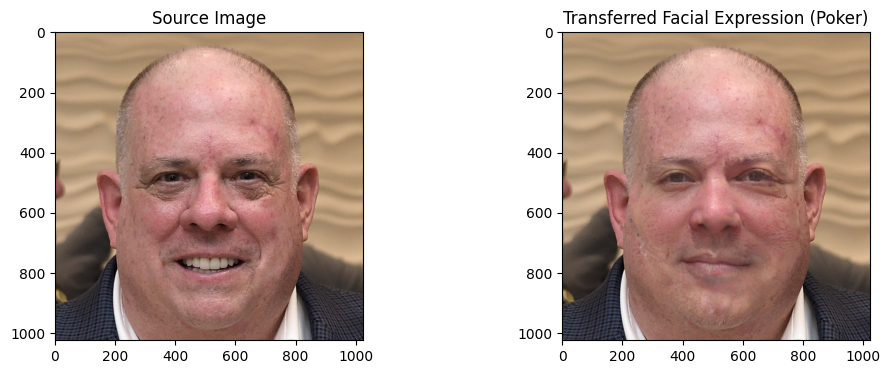

In [ ]:
test1_source = image_reader('source_image/test1.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test1.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (Poker)')

plt.show()

In [ ]:
change_expression(src_img='test3.png', prompt='poker')

Start Encoding...
iter500: loss -- 1.8769586086273193,  mse_loss --0.018908534198999405,  percep_loss --1.8580501079559326

Most similar image is 70th source image. with similarity equal to 0.08949802070856094.

Start Transfer Expression...
iter0:   loss0 --7.038455009460449,  loss1 --3.555950911504624e-07
iter100:   loss0 --2.4883217811584473,  loss1 --1.2522494330369227e-07
iter200:   loss0 --1.8734413385391235,  loss1 --1.0505633696311634e-07
iter300:   loss0 --1.7451063394546509,  loss1 --9.326654293317915e-08
iter400:   loss0 --1.4629515409469604,  loss1 --8.403269902146349e-08
iter500:   loss0 --1.4685872793197632,  loss1 --8.200204604236205e-08


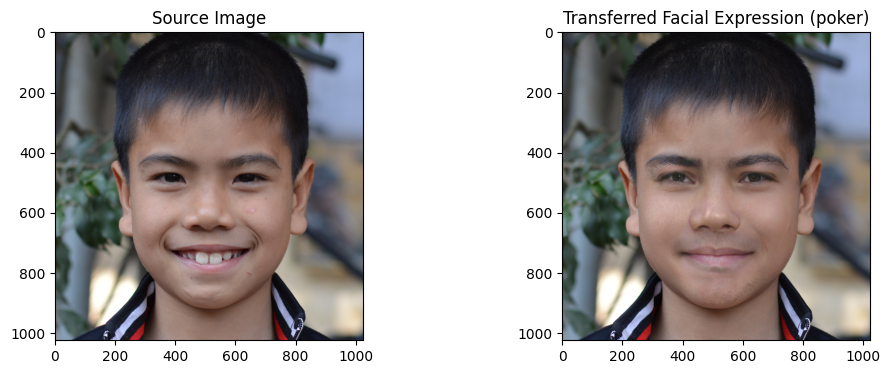

In [ ]:
test1_source = image_reader('source_image/test3.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test3.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (poker)')

plt.show()

In [ ]:
change_expression(src_img='test7.png', prompt='sad')

Start Encoding...
iter500: loss -- 2.0558159351348877,  mse_loss --0.011521677486598492,  percep_loss --2.0442943572998047

Most similar image is 77th source image. with similarity equal to 0.0974479466676712.

Start Transfer Expression...
iter0:   loss0 --7.183595180511475,  loss1 --3.869960210067802e-07
iter100:   loss0 --1.8766334056854248,  loss1 --1.1260713961291913e-07
iter200:   loss0 --1.656642198562622,  loss1 --1.011536454598172e-07
iter300:   loss0 --1.6072545051574707,  loss1 --9.271594336723865e-08
iter400:   loss0 --1.4861397743225098,  loss1 --8.648490279483667e-08
iter500:   loss0 --1.2832285165786743,  loss1 --8.71958931725203e-08


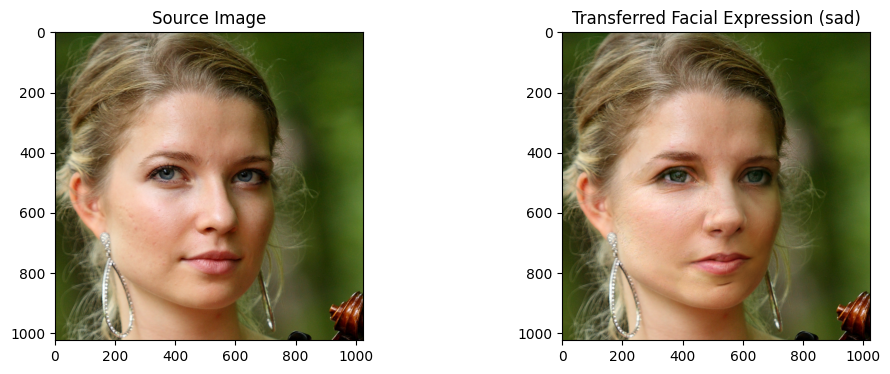

In [ ]:
test1_source = image_reader('source_image/test7.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test7.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (sad)')

plt.show()

In [ ]:
change_expression(src_img='test1.png', prompt='sad')

Start Encoding...
iter500: loss -- 1.854482650756836,  mse_loss --0.011917034164071083,  percep_loss --1.842565655708313

Most similar image is 54th source image. with similarity equal to 0.05576832965016365.

Start Transfer Expression...
iter0:   loss0 --7.961899757385254,  loss1 --4.663420725137257e-07
iter100:   loss0 --2.734920024871826,  loss1 --1.1613677486366214e-07
iter200:   loss0 --2.2352821826934814,  loss1 --9.755791552379378e-08
iter300:   loss0 --1.9503788948059082,  loss1 --8.7592347597365e-08
iter400:   loss0 --1.9437881708145142,  loss1 --7.851299699268566e-08
iter500:   loss0 --1.8401944637298584,  loss1 --7.369577303961705e-08


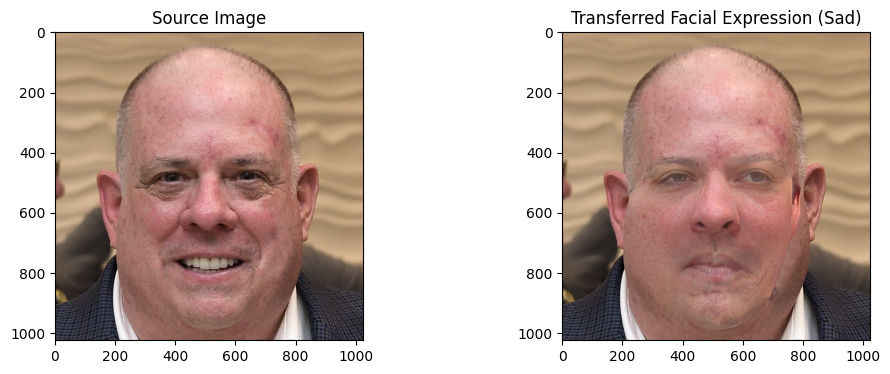

In [ ]:
test1_source = image_reader('source_image/test1.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test1.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (Sad)')

plt.show()

In [ ]:
change_expression(src_img='test4.png', prompt='sad')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 248MB/s]


Start Encoding...
iter500: loss -- 2.626084327697754,  mse_loss --0.011825560592114925,  percep_loss --2.6142587661743164

Most similar image is 24th source image. with similarity equal to 0.0656215101480484.

Start Transfer Expression...
iter0:   loss0 --8.305730819702148,  loss1 --6.280271236391854e-07
iter100:   loss0 --3.415485143661499,  loss1 --1.8957692304866214e-07
iter200:   loss0 --2.870151996612549,  loss1 --1.578507635713322e-07
iter300:   loss0 --2.5433237552642822,  loss1 --1.3516046237782575e-07
iter400:   loss0 --2.1631906032562256,  loss1 --1.1921584075480496e-07
iter500:   loss0 --1.9751876592636108,  loss1 --1.221048933075508e-07


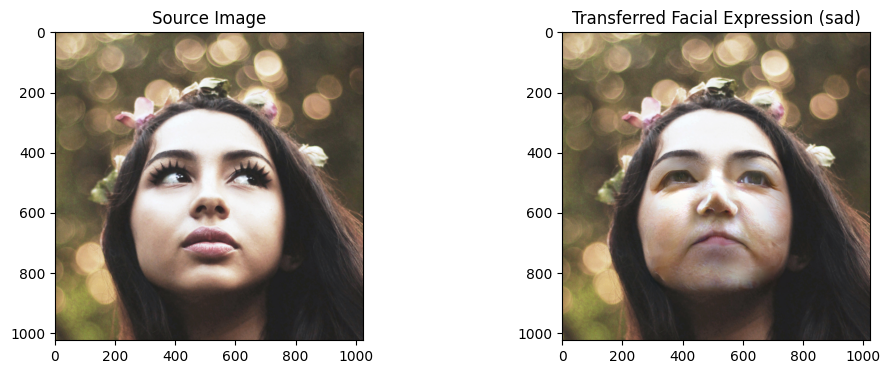

In [ ]:
test1_source = image_reader('source_image/test4.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test4.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (sad)')

plt.show()

In [ ]:
change_expression(src_img='test5.png', prompt='happy')

Start Encoding...
iter500: loss -- 3.754150867462158,  mse_loss --0.027878612279891968,  percep_loss --3.7262723445892334

Most similar image is 94th source image. with similarity equal to 0.09688401222229004.

Start Transfer Expression...
iter0:   loss0 --7.10728645324707,  loss1 --5.968050800220226e-07
iter100:   loss0 --2.70341157913208,  loss1 --2.3595607956394815e-07
iter200:   loss0 --2.225809097290039,  loss1 --1.985199560294859e-07
iter300:   loss0 --1.8474154472351074,  loss1 --1.6766657040534483e-07
iter400:   loss0 --1.660205602645874,  loss1 --1.603286250428937e-07
iter500:   loss0 --1.558558464050293,  loss1 --1.6062546137618483e-07


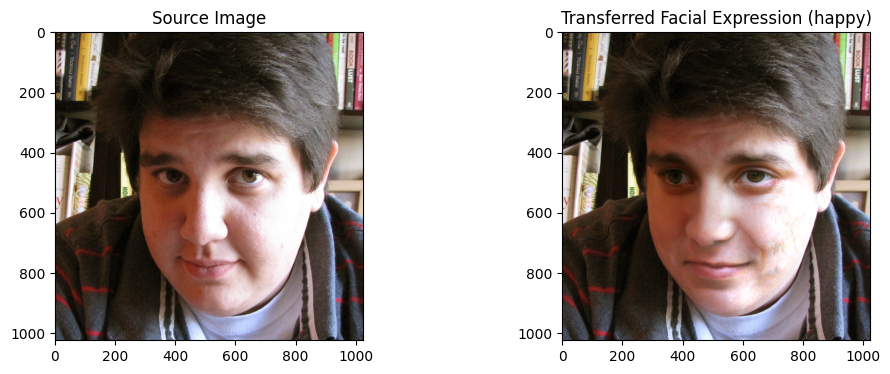

In [ ]:
test1_source = image_reader('source_image/test5.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test5.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (happy)')

plt.show()

In [ ]:
change_expression(src_img='test11.png', prompt='happy')

Start Encoding...
iter500: loss -- 2.7655205726623535,  mse_loss --0.0158762838691473,  percep_loss --2.7496442794799805

Most similar image is 64th source image. with similarity equal to 0.11496495455503464.

Start Transfer Expression...
iter0:   loss0 --9.331335067749023,  loss1 --4.1362639535691414e-07
iter100:   loss0 --4.751857280731201,  loss1 --1.7908985228132224e-07
iter200:   loss0 --4.267879009246826,  loss1 --1.514580105776986e-07
iter300:   loss0 --3.797210454940796,  loss1 --1.3390734920903924e-07
iter400:   loss0 --3.5505993366241455,  loss1 --1.254036163800265e-07
iter500:   loss0 --3.282458543777466,  loss1 --1.1517671794081252e-07


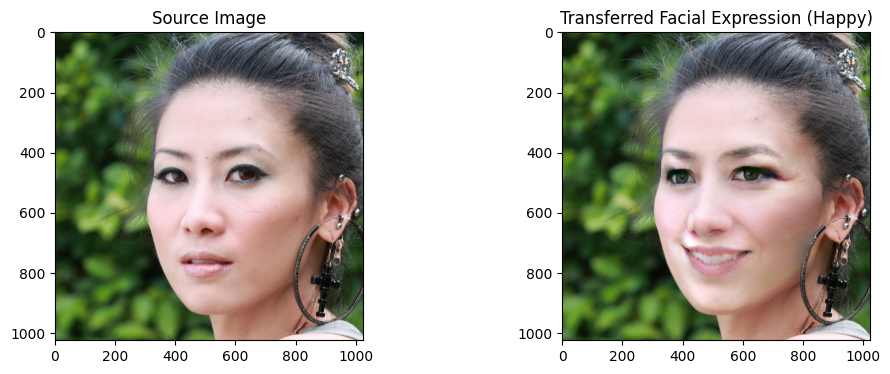

In [ ]:
test1_source = image_reader('source_image/test11.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test11.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (Happy)')

plt.show()

In [ ]:
change_expression(src_img='test7.png', prompt='happy')

Start Encoding...
iter500: loss -- 2.051241874694824,  mse_loss --0.00918666087090969,  percep_loss --2.042055130004883

Most similar image is 100th source image. with similarity equal to 0.1478298157453537.

Start Transfer Expression...
iter0:   loss0 --8.219364166259766,  loss1 --3.6673085901384184e-07
iter100:   loss0 --3.3244094848632812,  loss1 --1.1657594711778074e-07
iter200:   loss0 --2.7709152698516846,  loss1 --1.0238284176011803e-07
iter300:   loss0 --2.464353084564209,  loss1 --9.680761081654055e-08
iter400:   loss0 --2.1863157749176025,  loss1 --9.797717837045639e-08
iter500:   loss0 --2.126870632171631,  loss1 --9.215948182372813e-08


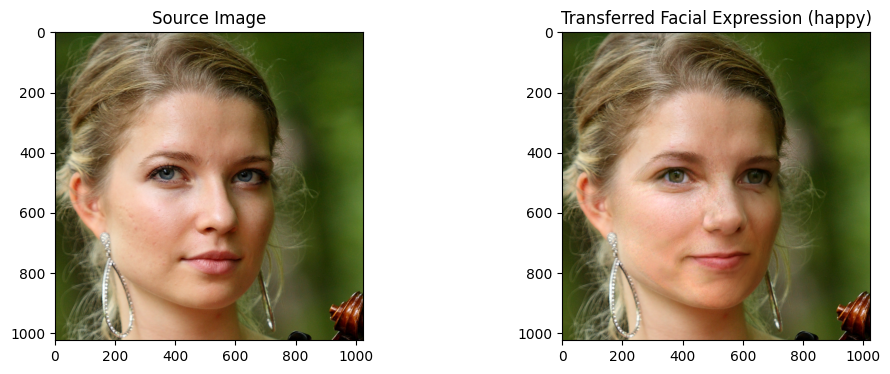

In [ ]:
test1_source = image_reader('source_image/test7.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test7.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (happy)')

plt.show()

In [ ]:
change_expression(src_img='test8.png', prompt='sad')

Start Encoding...
iter500: loss -- 2.299799919128418,  mse_loss --0.009590602479875088,  percep_loss --2.2902092933654785

Most similar image is 61th source image. with similarity equal to 0.05862537771463394.

Start Transfer Expression...
iter0:   loss0 --7.490080833435059,  loss1 --5.599231371888891e-07
iter100:   loss0 --2.9988059997558594,  loss1 --1.509112479425312e-07
iter200:   loss0 --2.447049617767334,  loss1 --1.3411386134976055e-07
iter300:   loss0 --2.297778606414795,  loss1 --1.2274051641725237e-07
iter400:   loss0 --1.990760087966919,  loss1 --1.1676862499143681e-07
iter500:   loss0 --1.8951241970062256,  loss1 --1.192113927572791e-07


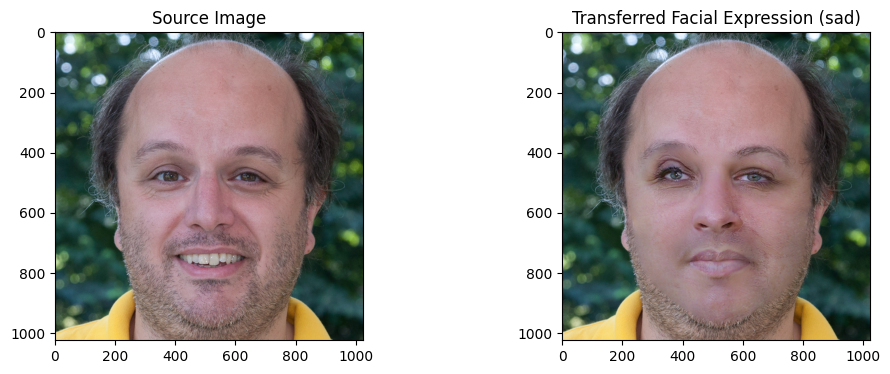

In [ ]:
test1_source = image_reader('source_image/test8.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test8.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (sad)')

plt.show()

In [ ]:
change_expression(src_img='test8.png', prompt='poker')

Start Encoding...
iter500: loss -- 2.5185976028442383,  mse_loss --0.015982728451490402,  percep_loss --2.502614974975586

Most similar image is 10th source image. with similarity equal to 0.07610629498958588.

Start Transfer Expression...
iter0:   loss0 --8.228195190429688,  loss1 --5.659981070493814e-07
iter100:   loss0 --3.033064365386963,  loss1 --1.504219824255415e-07
iter200:   loss0 --2.240706205368042,  loss1 --1.3447177593661763e-07
iter300:   loss0 --1.8970615863800049,  loss1 --1.17214703720947e-07
iter400:   loss0 --1.6788021326065063,  loss1 --9.738765527345095e-08
iter500:   loss0 --1.4514598846435547,  loss1 --9.915702037233132e-08


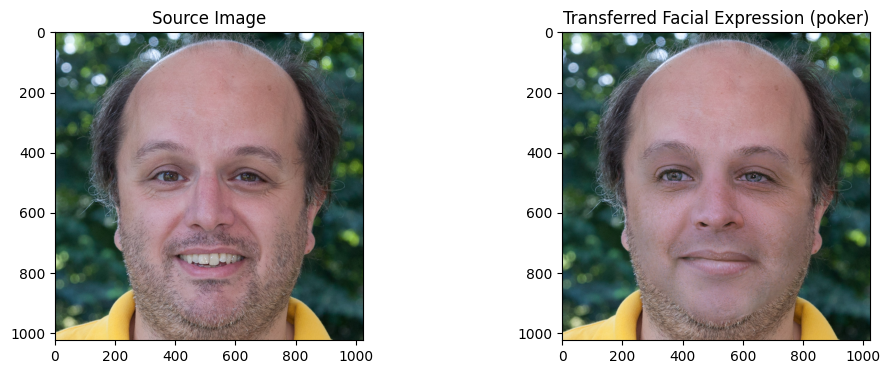

In [ ]:
test1_source = image_reader('source_image/test8.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test8.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (poker)')

plt.show()

In [ ]:
change_expression(src_img='test10.png', prompt='poker')

Start Encoding...
iter500: loss -- 1.0939157009124756,  mse_loss --0.004332898184657097,  percep_loss --1.0895828008651733

Most similar image is 18th source image. with similarity equal to 0.07259675860404968.

Start Transfer Expression...
iter0:   loss0 --8.21706771850586,  loss1 --5.117524892739311e-07
iter100:   loss0 --3.4049763679504395,  loss1 --1.1785348874582269e-07
iter200:   loss0 --2.567689895629883,  loss1 --1.0192903232564277e-07
iter300:   loss0 --2.1870155334472656,  loss1 --8.337339352237905e-08
iter400:   loss0 --1.9261322021484375,  loss1 --7.185845163348858e-08
iter500:   loss0 --1.7809925079345703,  loss1 --7.216878117333181e-08


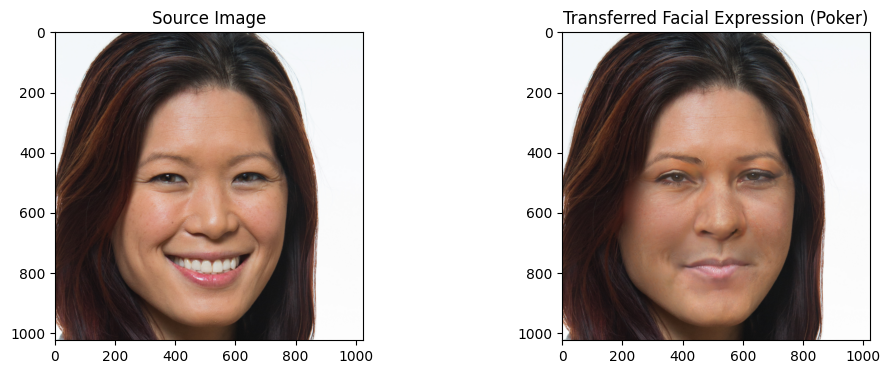

In [ ]:
test1_source = image_reader('source_image/test10.png').squeeze().permute(1, 2, 0) # Source image

src_img = 'save_image/exchange/transferred/500_transferred.png'
dst_img = 'source_image/test10.png'
test1_result = wrap_blend(src_img, dst_img) # Transffered image after wrapping

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # # Create a figure with two subplots in one row

axs[0].imshow(test1_source)
axs[0].set_title('Source Image')

axs[1].imshow(test1_result[:, :, ::-1])
axs[1].set_title('Transferred Facial Expression (Poker)')

plt.show()